In [28]:
import torch 
from torch import nn
import json

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights 

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
print(torch.__version__)

2.5.1+cu121


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from pathlib import Path

data_root = Path("food-101")
print(data_root.exists())
print((data_root / "images").exists())
print((data_root / "meta").exists())

True
True
True


In [5]:
from food101_dataset import idx_food101, Food101Dataset, load_json
samples, class_to_idx = idx_food101("food-101")

data = Food101Dataset(samples, class_to_idx)
print(len(data))

img, label = data[10001]
print(type(img), label)

101000
<class 'PIL.Image.Image'> 10


In [6]:
samples, class_to_idx = idx_food101("food-101")
print(len(class_to_idx))
print(list(class_to_idx.keys())[:10])

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [7]:
# from sklearn.model_selection import train_test_split

# samples, class_to_idx = idx_food101("food-101")
# labels = [label for _, label in samples]

# train_set, temp_set = train_test_split(
#     samples,
#     test_size=0.2,
#     stratify=labels,
#     random_state=78
# )

# temp_set_labels = [label for _, label in temp_set]

# val_set, test_set = train_test_split(
#     temp_set,
#     test_size = 0.5,
#     stratify=temp_set_labels,
#     random_state=78
# )

In [8]:
# output_dir = Path("data")
# output_dir.mkdir(parents=True, exist_ok=True)

# json.dump(train_set, open("data/train.json", "w"))  
# json.dump(val_set, open("data/val.json", "w"))
# json.dump(test_set, open("data/test.json", "w"))
# json.dump(class_to_idx, open("data/class_to_idx.json", "w"))

In [9]:
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
     
])

In [10]:
train_samples = load_json("data/train.json")
val_samples = load_json("data/val.json")
test_samples = load_json("data/test.json")
class_to_idx = load_json("data/class_to_idx.json")

train_ds = Food101Dataset(train_samples, class_to_idx, transform=train_tf)
test_ds = Food101Dataset(test_samples, class_to_idx, transform=val_tf)
val_ds = Food101Dataset(val_samples, class_to_idx, transform=val_tf)

In [11]:
print(f"Train set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Class mapping saved for {len(class_to_idx)} classes")

Train set: 80800 samples
Validation set: 10100 samples
Test set: 10100 samples
Class mapping saved for 101 classes


In [12]:
# CALCULATING THE MEAN AND STD OF THE DATASET ITSELF


# tmp_tf = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor()
# ])

# train_tmp = Food101Dataset(train_samples, class_to_idx, transform=tmp_tf)

# tr_dl = DataLoader(train_tmp, batch_size = 64, shuffle = False, num_workers=4)

# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_pixels = 0

# for imgs, _ in tr_dl:
#     b,c,h,w = imgs.shape
#     pixels = b*h*w

#     mean += imgs.sum(dim = [0,2,3])
#     std += (imgs**2).sum(dim = [0,2,3])
#     n_pixels += pixels

# mean = mean / n_pixels
# std = (std / n_pixels - mean**2).sqrt()

# print(f"Mean: {mean}")
# print(f"Standard deviation: {std}")

In [13]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers = 4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers = 4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers = 4, pin_memory=True)

In [14]:
images, labels = next(iter(train_loader))

print(images.shape)
print(images.dtype)
print(labels.shape)
print(labels.dtype)

torch.Size([32, 3, 224, 224])
torch.float32
torch.Size([32])
torch.int64


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

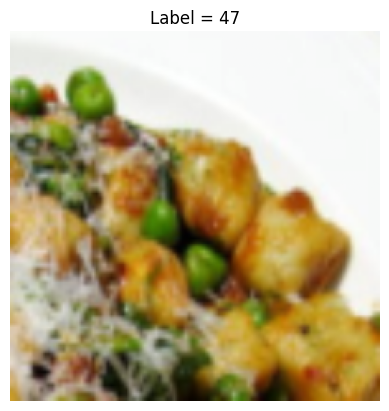

In [15]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

img = images[5]
img = img * std + mean
img = img.clamp(0,1)
img = img.permute(1,2,0)

plt.imshow(img)
plt.title(f"Label = {labels[5].item()}")
plt.axis("off")

In [16]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights = weights)

In [17]:
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [18]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

In [19]:
model = model.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.fc.parameters(),
    lr = 1e-3,
    weight_decay=1e-4
)

In [26]:
def train_one_epoch(model, dt_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(dt_loader, desc='Train', leave = False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = out.argmax(dim = 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss = loss.item())
    return total_loss / total, correct / total

In [27]:
def validation_loop(model, dt_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dt_loader:
            images = images.to(device)
            labels = labels.to(device)

            outs = model(images)
            loss = criterion(outs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outs.argmax(dim = 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

In [29]:
best_val_acc = 0.0
patience = 3
patience_counter = 0

EPOCHS = 15
min_delta = 1e-3

for epoch in trange(EPOCHS, desc='Epochs'):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, val_acc = validation_loop(model, val_loader, criterion, device)
    
    print(
        f'Epoch {epoch+1} |'
        f'Train accuracy: {train_acc:.4f} |'
        f'Val accuracy: {val_acc:.4f} |'
        )
    
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered") 
        break

Epochs:   7%|▋         | 1/15 [19:55<4:38:54, 1195.31s/it]

Epoch 1 |Train accuracy: 0.3977 |Val accuracy: 0.5455 |


Epochs:  13%|█▎        | 2/15 [26:46<2:39:01, 733.93s/it] 

Epoch 2 |Train accuracy: 0.5047 |Val accuracy: 0.5771 |


Epochs:  20%|██        | 3/15 [33:22<1:55:56, 579.67s/it]

Epoch 3 |Train accuracy: 0.5322 |Val accuracy: 0.5801 |


Epochs:  27%|██▋       | 4/15 [39:58<1:32:58, 507.15s/it]

Epoch 4 |Train accuracy: 0.5494 |Val accuracy: 0.6007 |


Epochs:  33%|███▎      | 5/15 [46:49<1:18:45, 472.53s/it]

Epoch 5 |Train accuracy: 0.5587 |Val accuracy: 0.6020 |


Epochs:  40%|████      | 6/15 [53:34<1:07:26, 449.56s/it]

Epoch 6 |Train accuracy: 0.5658 |Val accuracy: 0.5964 |


Epochs:  47%|████▋     | 7/15 [1:00:05<57:22, 430.34s/it]

Epoch 7 |Train accuracy: 0.5703 |Val accuracy: 0.5976 |


Epochs:  53%|█████▎    | 8/15 [1:06:40<48:53, 419.01s/it]

Epoch 8 |Train accuracy: 0.5710 |Val accuracy: 0.6041 |


Epochs:  60%|██████    | 9/15 [1:13:18<41:14, 412.49s/it]

Epoch 9 |Train accuracy: 0.5758 |Val accuracy: 0.5997 |


Epochs:  67%|██████▋   | 10/15 [1:20:17<34:32, 414.59s/it]

Epoch 10 |Train accuracy: 0.5786 |Val accuracy: 0.6076 |


Epochs:  73%|███████▎  | 11/15 [1:27:05<27:29, 412.46s/it]

Epoch 11 |Train accuracy: 0.5795 |Val accuracy: 0.6027 |


Epochs:  80%|████████  | 12/15 [1:34:01<20:41, 413.78s/it]

Epoch 12 |Train accuracy: 0.5840 |Val accuracy: 0.6101 |


Epochs:  87%|████████▋ | 13/15 [1:41:06<13:54, 417.17s/it]

Epoch 13 |Train accuracy: 0.5850 |Val accuracy: 0.6108 |


Epochs:  93%|█████████▎| 14/15 [1:47:49<06:52, 412.82s/it]

Epoch 14 |Train accuracy: 0.5846 |Val accuracy: 0.6094 |


Epochs:  93%|█████████▎| 14/15 [1:54:18<08:09, 489.91s/it]

Epoch 15 |Train accuracy: 0.5900 |Val accuracy: 0.6051 |
Early stopping triggered
